# Projeto do Trainee: Data Science
Esse notebook foi realizado por $Wesley$ $Pereira$ para o projeto do trainee de Data Science do primeiro semestre de 2020.<br/>
<img src="https://i.ibb.co/DtHQ3FG/802x265-Logo-GT.png" width="400"><br/>
O projeto é constutuído de 2 partes principais:
<ul>
<li> Web Scraping da página <code>https://scrapethissite.com/pages/forms/</code> que contém dados sobre o desempenho de diversas equipes de Hockey no Gelo nos últimos anos. </li>
<li> Análise dos dados obtidos, assim como do dataset <code>DataSet ESPN.csv</code> fornecido no enunciado do projeto.</li>
<ul>

## 1. Web Scraping
O Web Scraping permite a coleta de dados em sites específicos. Para realizar tal tarefa utilizaremos as duas bibliotecas:
<ul>
    <li><strong>urllib</strong>: Para acessar o site e fazer a aquisição do código-fonte(html) </li>
    <li><strong>BeautifulSoup</strong>: Para trabalhar com o html e obter as tabelas necessárias </li>
</ul>
Primeiro, vamos importar as bibliotecas necessárias para adquirir o html do site.

In [3]:
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError

Em seguida, iremos definir o url base e o cabeçalho que o site utiliza

In [4]:
url = 'https://scrapethissite.com/pages/forms/?page_num=1&per_page=100'
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36'}

Assim, podemos fazer o _request_ para obter todo o html

In [5]:
try:
    # Faz o request para o site
    req = Request(url, headers = headers)
    
    # Capta a resposta da requisição e lê o código-fonte
    response = urlopen(req)
    html = response.read()

#Tratamento de erros comuns em requisições http
except URLError as e:
    print(e.status, e.reason)

except HTTPError as e:
    print(e.reason)

In [6]:
# Transformação simples em código utf-8
html = html.decode('utf-8')

Vamos agora criar um objeto do tipo ```BeautifulSoup```, que nos auxiliará a investigar e extrair os dados do código html.

In [7]:
from bs4 import BeautifulSoup

#Cria o objeto BeautifulSoup utilizando o parser padrão de html
soup = BeautifulSoup(html, 'html.parser')

Tendo o html de tal modo que possamos trabalhá-lo, iremos agora encontrar a quantidade de páginas que devemos varrer.

In [8]:
# Encontra a ul que representa a paginação do site
paginacao = soup.find_all('ul', class_='pagination')[0]

# Dentro dessa ul pegamos todas as li
paginacao_itens = paginacao.find_all('li')

# Analisando o site percebemos que que a li onde fica a última página é a penútima ul [-2]
# Isso se deve ao fato do site ter uma li dedicada a avançar para a página seguinte.
ult_pagina = int(paginacao_itens[-2].get_text())
print(ult_pagina)

6


<p>Agora que sabemos quantas páginas temos, podemos rodar um loop parecido com o feito acima para obter as tabelas da página. Primeiro, criamos o <code>url_base</code> conforme o número da página que queremos obter o código-fonte. Em seguida, fazemos a requisiçao e adquirimos o html, conforme já feito anteriormente. Por fim, obtemos a tabela e adicionamos no dicionários de dataframes criado. 

In [9]:
import pandas as pd

# Dicionário criado para armazenar os dataframes obtidos de cada página
all_df = {}

# Loop que obtém, transforma e armazena os dataframes do site
for page in range(1, ult_pagina+1):
    
    base_url = 'https://scrapethissite.com/pages/forms/?page_num=' + str(page) + '&per_page=100'
    
    try: 
        req = Request(base_url, headers = headers)
        response = urlopen(req)
        html = response.read()

    except URLError as e:
        print(e.status, e.reason)

    except HTTPError as e:
        print(e.reason)
        
    soup = BeautifulSoup(html, 'html.parser')
    
    # Obtém a tabela da página
    table = soup.find_all('table')[0]
    
    # Transforma a tabela em dataframe e adiciona no dicionário
    all_df["df" + str(page)] = pd.read_html(str(table))[0]
    
    print('DataFrame ' + str(page) + ' extraído com sucesso.' )
print('Cabô.')

DataFrame 1 extraído com sucesso.
DataFrame 2 extraído com sucesso.
DataFrame 3 extraído com sucesso.
DataFrame 4 extraído com sucesso.
DataFrame 5 extraído com sucesso.
DataFrame 6 extraído com sucesso.
Cabô.


In [10]:
# Visualização de um dos dataframes obtidos
all_df["df2"].head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Edmonton Oilers,1994,17,27,NaN,0.354,136,183,-47
1,Florida Panthers,1994,20,22,NaN,0.417,115,127,-12
2,Hartford Whalers,1994,19,24,NaN,0.396,127,141,-14
3,Los Angeles Kings,1994,16,23,NaN,0.333,142,174,-32
4,Montreal Canadiens,1994,18,23,NaN,0.375,125,148,-23


A seguir vamos juntar todos os dataframes em um único.

In [11]:
# Função auxiliar que une 2 dataframes
def une_dataframes(df1, df2):
    return df1.append(df2, ignore_index=True)

# Loop para juntar os dataframes
df = pd.DataFrame()
for key in all_df.keys():
    df = une_dataframes(df, all_df[key])

Por último, salvar o dataframe

In [12]:
df.to_csv('./hockey_teams.csv')

## 2. Análise de Dados

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Lendo os datasets
df_Teams = df
df_ESPN = pd.read_csv('DataSet ESPN.csv', index_col=0, thousands=',')

# Tamanho dos dataframes lidos
print('Shape do dataframe df_Teams: ' + str(df_Teams.shape))
print('Shape do dataframe df_ESPN: ' + str(df_ESPN.shape))

Shape do dataframe df_Teams: (582, 9)
Shape do dataframe df_ESPN: (290, 12)


In [14]:
display(df_Teams.head())
display(df_ESPN.head())

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Boston Bruins,1990,44,24,NaN,0.550,299,264,35
1,Buffalo Sabres,1990,31,30,NaN,0.388,292,278,14
2,Calgary Flames,1990,46,26,NaN,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,NaN,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,NaN,0.425,273,298,-25


,Team,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against
0,Montreal Canadiens,41,824308,20105,41,16013,82,18059,2001,0.899,1020,1294
1,Detroit Red Wings,41,819795,19995,41,17889,82,18942,2001,0.909,1082,1072
2,Philadelphia Flyers,41,802595,19575,41,17182,82,18378,2001,0.903,1183,1332
3,St Louis Blues,41,800319,19519,41,16898,82,18209,2001,0.899,1345,1366
4,Toronto Maple Leafs,41,789567,19257,41,17172,82,18215,2001,0.908,1430,1243


In [15]:
display(df_Teams.shape)
display(df_ESPN.shape)

(582, 9)

(290, 12)

### Data Cleaning
Antes de mais nada, iremos limpar e deixar nossos dados da melhor maneira possível para trabalhá-los.<br/>
Vamos ter uma visão geral de algumas informações dos dados:

In [16]:
df_Teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 9 columns):
Team Name             582 non-null object
Year                  582 non-null int64
Wins                  582 non-null int64
Losses                582 non-null int64
OT Losses             358 non-null float64
Win %                 582 non-null float64
Goals For (GF)        582 non-null int64
Goals Against (GA)    582 non-null int64
+ / -                 582 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 41.0+ KB


In [17]:
df_Teams.isna().any()

Team Name             False
Year                  False
Wins                  False
Losses                False
OT Losses              True
Win %                 False
Goals For (GF)        False
Goals Against (GA)    False
+ / -                 False
dtype: bool

In [18]:
df_ESPN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 289
Data columns (total 12 columns):
Team                       290 non-null object
Home Games                 290 non-null int64
Home Total                 290 non-null int64
Home Average               290 non-null int64
Road Games                 290 non-null int64
Road Average               290 non-null int64
Overall Games              290 non-null int64
Overall Average            290 non-null int64
Year                       290 non-null int64
Save Percentage            290 non-null float64
Penalty Minutes            290 non-null int64
Penalty Minutes Against    290 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 29.5+ KB


In [19]:
df_ESPN.isna().any()

Team                       False
Home Games                 False
Home Total                 False
Home Average               False
Road Games                 False
Road Average               False
Overall Games              False
Overall Average            False
Year                       False
Save Percentage            False
Penalty Minutes            False
Penalty Minutes Against    False
dtype: bool

Das tabelas acima podemos tirar algumas conclusões:
<ul>
    <li>A única coluna que possui NaN é a <code>OT Losses</code> do dataset <code>df_Teams</code>, que podem ser substituídos por 0, pois no site original a ausência de valores denota 0 derrotas;</li>
    <li>As demais colunas parecem estar corretas para podermos trabalhar.</li>
</ul>

In [20]:
# Tranformando os NaN em 0.0
df_Teams = df_Teams.fillna(0)

In [21]:
df_Teams.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Boston Bruins,1990,44,24,0.0,0.550,299,264,35
1,Buffalo Sabres,1990,31,30,0.0,0.388,292,278,14
2,Calgary Flames,1990,46,26,0.0,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,0.0,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,0.0,0.425,273,298,-25


Para finalizar, vamos apenas nos certificar da existência de _outliers_ no dataset.

In [22]:
df_Teams.describe()

,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,2000.907216,36.943299,32.353952,4.589347,0.458526,234.063574,234.063574,0.000000
std,6.330674,8.926081,8.411439,4.605402,0.102235,40.548915,42.510718,45.277458
min,1990.000000,9.000000,11.000000,0.000000,0.119000,115.000000,115.000000,-196.000000
25%,1996.000000,31.000000,27.000000,0.000000,0.390000,211.000000,207.000000,-27.000000
50%,2001.000000,38.000000,31.000000,4.000000,0.463000,231.000000,232.500000,4.000000
75%,2007.000000,43.000000,37.000000,8.000000,0.534000,254.000000,258.750000,31.000000
max,2011.000000,62.000000,71.000000,18.000000,0.756000,369.000000,414.000000,144.000000


In [23]:
df_ESPN.describe()

,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against
count,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,40.962069,696862.827586,17012.513793,40.962069,16948.351724,81.924138,16980.437931,2006.100000,0.905528,1169.444828,1170.213793
std,0.224632,89095.441449,2177.902099,0.224632,589.707740,0.425531,1191.551650,3.305704,0.009384,194.635349,173.543397
min,40.000000,453456.000000,11059.000000,40.000000,15575.000000,80.000000,14026.000000,2001.000000,0.884000,710.000000,696.000000
25%,41.000000,632779.750000,15433.000000,41.000000,16567.500000,82.000000,16096.000000,2003.000000,0.899250,1038.250000,1055.500000
50%,41.000000,703766.000000,17210.500000,41.000000,16956.500000,82.000000,17018.500000,2006.500000,0.906000,1170.500000,1165.000000
75%,41.000000,760915.000000,18566.000000,41.000000,17317.000000,82.000000,17878.250000,2009.000000,0.913000,1286.500000,1283.000000
max,42.000000,912155.000000,22247.000000,42.000000,19002.000000,84.000000,19896.000000,2011.000000,0.930000,1994.000000,1818.000000


Analisando as variâncias dos datasets, percebemos que nenhuma coluna possui algum valor muito discrepante (o que causaria uma alta variância). Com isso já podemos começar a analisar de fato nossos dados.

### Qual time é o mais vencedor no período de 1990 a 2011?
Qual time possui maior quantidade de vitórias únicas dentro do período de 1990 a 2011?

In [28]:
import numpy as np

vitorias_por_time = df_Teams.groupby('Team Name', as_index=False)['Wins'].sum()
vitorias_por_time.nlargest(5, 'Wins')

,Team Name,Wins
10,Detroit Red Wings,986
20,New Jersey Devils,905
26,Pittsburgh Penguins,839
24,Philadelphia Flyers,836
2,Boston Bruins,816


Média geral de vitórias únicas: 614.3142857142857
Vitórias do Detroit Red Wings: 986


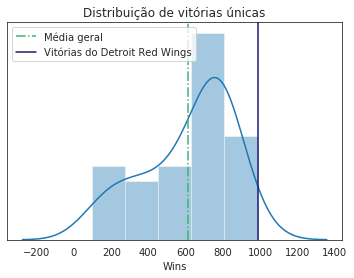

In [29]:
# Cria gráfico da distribuição das vitórias
ax = sns.distplot(vitorias_por_time['Wins'])

media_geral_vit = vitorias_por_time['Wins'].mean()
vit_detroit = vitorias_por_time['Wins'].max()

print("Média geral de vitórias únicas: " + str(media_geral_vit))
print("Vitórias do Detroit Red Wings: " + str(vit_detroit))

# Cria linhas auxiliares do comparativo da média de vitórias e do time mais vitorioso
ax.axvline(media_geral_vit, c="mediumseagreen", linestyle="dashdot", label="Média geral")
ax.axvline(vit_detroit, c="midnightblue", label= "Vitórias do Detroit Red Wings")
ax.legend(loc='upper left')
ax.get_yaxis().set_visible(False)
plt.title("Distribuição de vitórias únicas")
plt.show()

#### Mas... Será que o time com mais vitórias é de fato o mais vitorioso? <br/>
Para isso, iremos avaliar a porcentagem de vitória dos times!

In [30]:
pct_vitorias_por_time = df_Teams.groupby('Team Name', as_index=False)['Win %'].mean()
pct_vitorias_por_time.nlargest(5, 'Win %')

,Team Name,Win %
10,Detroit Red Wings,0.586000
20,New Jersey Devils,0.534333
0,Anaheim Ducks,0.522333
9,Dallas Stars,0.516889
7,Colorado Avalanche,0.516062


Média geral de % de vitórias: 0.4509727558051806
% de vitórias do Detroit Red Wings: 0.5860000000000001


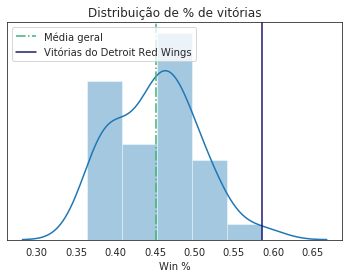

In [31]:
# Cria gráfico da distribuição das % de vitórias
ax = sns.distplot(pct_vitorias_por_time['Win %'])

pct_media_geral_vit = pct_vitorias_por_time['Win %'].mean()
pct_vit_detroit = pct_vitorias_por_time['Win %'].max()

print("Média geral de % de vitórias: " + str(pct_media_geral_vit))
print("% de vitórias do Detroit Red Wings: " + str(pct_vit_detroit))

# Cria linhas auxiliares do comparativo da média de vitórias e do time mais vitorioso
ax.axvline(pct_media_geral_vit, c="mediumseagreen", linestyle="dashdot", label="Média geral")
ax.axvline(pct_vit_detroit, c="midnightblue", label= "Vitórias do Detroit Red Wings")
ax.legend(loc='upper left')
ax.get_yaxis().set_visible(False)
plt.title("Distribuição de % de vitórias")
plt.show()

De fato, **Detroit Red Wings** domina o Hockey no Gelo! Tanto em vitórias únicas, quanto em aproveitamento dos jogos, o time é UMA MÁQUINA! Vamos agora então fazer uma análise rápida do time **Anaheim Ducks** para tentar entender sua boa porcentagem de vitórias, dado que ele nem figura entre os times com mais vitórias únicas.

In [32]:
# Vitórias únicas do Anaheim Ducks
vitorias_anaheim = df_Teams.groupby('Team Name', as_index=False)['Wins'].sum().loc[0]
display(vitorias_anaheim)

# Visualiza todas as passagens do time pela liga
display(df_Teams[df_Teams['Team Name'] == 'Anaheim Ducks'])

Team Name    Anaheim Ducks
Wins                   257
Name: 0, dtype: object

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
402,Anaheim Ducks,2006,48,20,14.0,0.585,258,208,50
432,Anaheim Ducks,2007,47,27,8.0,0.573,205,191,14
462,Anaheim Ducks,2008,42,33,7.0,0.512,245,238,7
492,Anaheim Ducks,2009,39,32,11.0,0.476,238,251,-13
522,Anaheim Ducks,2010,47,30,5.0,0.573,239,235,4
552,Anaheim Ducks,2011,34,36,12.0,0.415,204,231,-27


A partir do terceiro time, percebemos que mais vitórias únicas não se traduzem em um melhor aproveitamento. _Anaheim Ducks_ por exemplo, não possui tantas vitórias quanto Detroit Red Wings, principalmente pelo seu pouco tempo dentro da liga (entrou para a liga de  Hockey em 2006), mas teve bons desempenhos ao longo dos anos que participou do Hockey no Gelo.

### O torna um time UMA MÁQUINA dentro do gelo?
Torcida? Um bom ataque? Uma defesa robusta? Vamos tentar investigar o que leva um time ao auge nas pistas. Para isso utilizaremos ambos os datasets para considerarmos também a influência da torcida, jogos em casa, penalidades sofrida, entre outras _features_ que o dataset da ESPN nos fornece.

In [33]:
# Dando merge nos dois dataframes para trabalhar com alguns dados de ambos
merged_df = pd.merge(df_ESPN, df_Teams.rename(columns={"Team Name": "Team"}), on=['Year', 'Team'])
merged_df.head()

,Team,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Montreal Canadiens,41,824308,20105,41,16013,82,18059,2001,0.899,1020,1294,36,31,3.0,0.439,207,209,-2
1,Detroit Red Wings,41,819795,19995,41,17889,82,18942,2001,0.909,1082,1072,51,17,4.0,0.622,251,187,64
2,Philadelphia Flyers,41,802595,19575,41,17182,82,18378,2001,0.903,1183,1332,42,27,3.0,0.512,234,192,42
3,Toronto Maple Leafs,41,789567,19257,41,17172,82,18215,2001,0.908,1430,1243,43,25,4.0,0.524,249,207,42
4,New York Rangers,41,746200,18200,41,17628,82,17914,2001,0.887,1522,1395,36,38,4.0,0.439,227,258,-31


In [34]:
merged_df.shape

(237, 19)

Aqui percebemos que mais da metade das linhas do primeiro dataframe foi perdido, pois os dados do dataset da ESPN trabalham com dados apenas a partir de 2001. Além disso, como alguns times podem ter nomes diferentes em ambas as tabelas temos ainda menos dados do que o segundo dataset. Iremos lidar também com as duas tabelas separadas para tentar amenizar a redução na nossa amostragem.

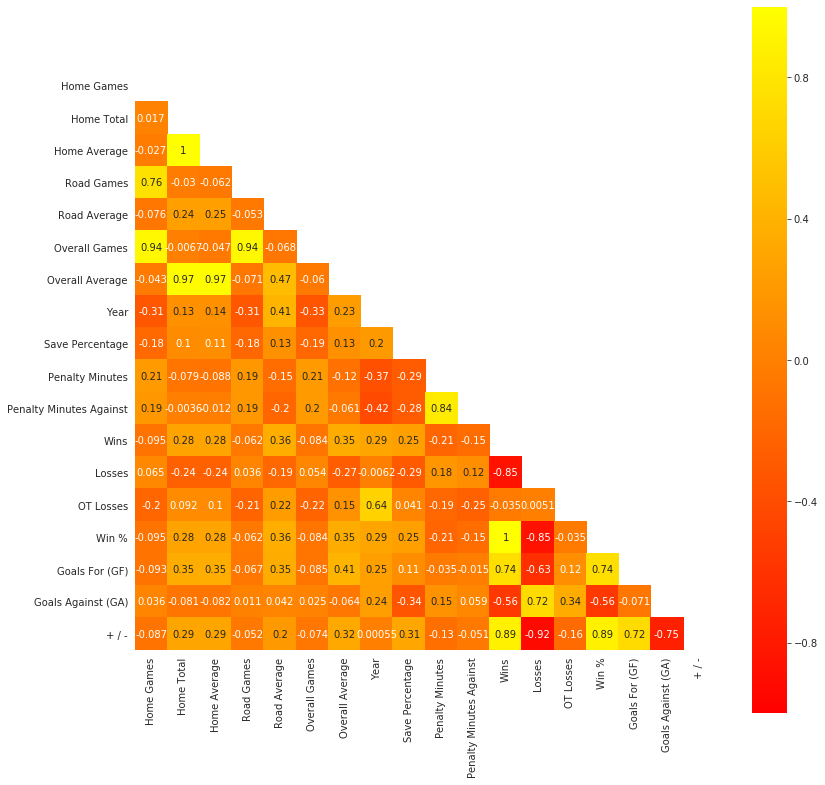

In [35]:
# define um triângulo matricial superior para não plotar os dados repidos
mask = np.triu(np.ones_like(merged_df.corr(), dtype=np.bool))

plt.figure(figsize=(13,13))

# Plota heatmap dos dados
sns.heatmap(merged_df.corr(), mask=mask, square = True, annot=True, vmin=-1, vmax=1, cmap='autumn')
plt.show()

Analisando o heatmap, percebemos alguns fatores interessantes sobre a taxa de vitórias de um time:
<ul>
    <li>A porcentagem de vitória de um time (Win %)está altamente ligada a quantos gols que ele realiza (Goals For);</li>
    <li>Além disso, um bom balanço entre gols marcados e gols sofridos (+/-) parece ser ainda mais importante pro bom desempenho de uma seleção!;</li>
</ul>
Vamos ver como esses dados se traduzem nos gráficos:

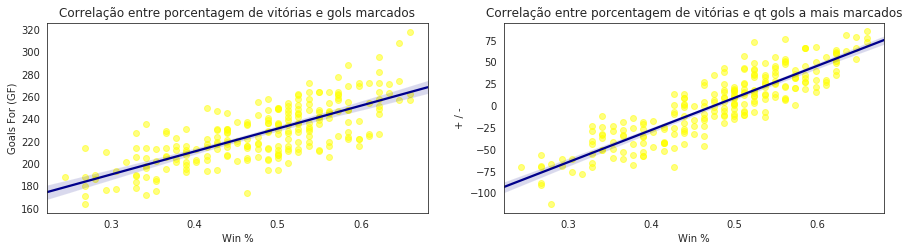

In [36]:
plt.figure(figsize=(15,3.5))

#Plota gráfico 1
plt.subplot(121)
sns.regplot(x ='Win %', y ='Goals For (GF)', data = merged_df, line_kws={'color':'darkblue'}, scatter_kws={'alpha':0.5,'color':'yellow'})
plt.title("Correlação entre porcentagem de vitórias e gols marcados")

#Plota gráfico 2
plt.subplot(122)
sns.regplot(x ='Win %', y ='+ / -', data = merged_df, line_kws={'color':'darkblue'}, scatter_kws={'alpha':0.5,'color':'yellow'} )
plt.title("Correlação entre porcentagem de vitórias e qt gols a mais marcados")
plt.show()

Bom... Mas até aí tudo dentro do esperado: Um time com bom ataque e com um bom equilíbrio em ataque e defesa se deu bem no campeonato. Percebemos analisando as correlações da porcentagem de vitórias que a média de torcedores nos jogos e, em especial, a média de torcedores em jogos fora de casa tem uma ***correlação positiva de cerca de 35%***! <br>
Além disso, a média de torcedores possui uma influência ainda maior na quantidade de gols marcados, possuindo ***correlação positiva de cerca de 41%.*** 

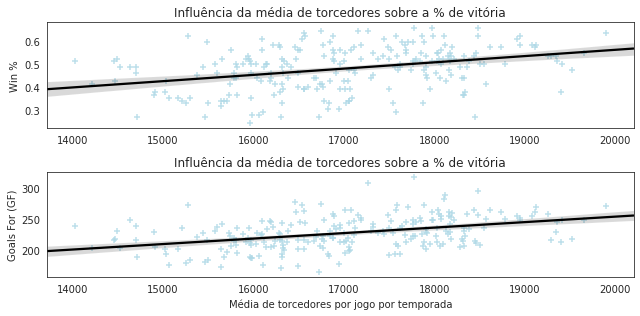

In [37]:
plt.figure(figsize=(9,4.5))

# Cria o primeiro subplot
plt.subplot(2, 1, 1)
sns.regplot('Overall Average', 'Win %', data=merged_df, marker="+", line_kws={'color':'black'}, scatter_kws={'color':'lightblue'})
plt.xlabel(None)
plt.title('Influência da média de torcedores sobre a % de vitória')

# Cria o segundo subplot
plt.subplot(2, 1, 2)
sns.regplot('Overall Average', 'Goals For (GF)', data=merged_df, marker="+", line_kws={'color':'black'}, scatter_kws={'color':'lightblue'})
plt.title('Influência da média de torcedores sobre a % de vitória')
plt.xlabel('Média de torcedores por jogo por temporada')

# Melhora o espaçamento entre os gráficos
plt.tight_layout()

### E o que acontece com o pior time? Por que ele vai tão mal?
Agora já sabemos o que leva um time a vitória, entretanto, o que levar um time ao declínio? Vamos tentar descobrir um pouco mais.

In [38]:
pior_time_historia = pct_vitorias_por_time.nsmallest(1, 'Win %')['Team Name'].iloc[0]
print(pior_time_historia)

Hartford Whalers


Agora que sabemos qual pior time da história, o que torna o Hartford Whalers tão ruim?

In [39]:
dados_Team_Hartford = df_Teams[df_Teams['Team Name'] == pior_time_historia]
display(dados_Team_Hartford)

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
6,Hartford Whalers,1990,31,38,0.0,0.388,238,276,-38
27,Hartford Whalers,1991,26,41,0.0,0.325,247,283,-36
49,Hartford Whalers,1992,26,52,0.0,0.310,284,369,-85
76,Hartford Whalers,1993,27,48,0.0,0.321,227,288,-61
102,Hartford Whalers,1994,19,24,0.0,0.396,127,141,-14
129,Hartford Whalers,1995,34,39,0.0,0.415,237,259,-22
155,Hartford Whalers,1996,32,39,0.0,0.390,226,256,-30


Percebemos logo de cara que o Hartford Whalers foi tão muito ao longo de seus anos na liga que após 1996 o time simplesmente saiu das pistas de gelo do Hockey. Outro ponto importante que é que o saldo de gols do time aparentemente é horrível... 

In [40]:
saldo_gols_por_time = df_Teams.groupby('Team Name', as_index=False)['+ / -'].mean()
saldo_gols_Hartford = saldo_gols_por_time[saldo_gols_por_time['Team Name'] == pior_time_historia]

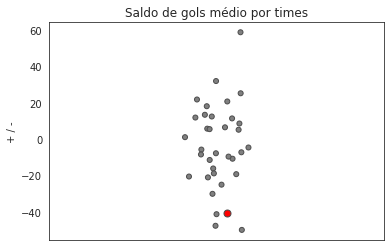

In [41]:
sns.stripplot(y = saldo_gols_por_time['+ / -'], linewidth=1, color="gray")
sns.stripplot(y = saldo_gols_Hartford['+ / -'], color='red', size=7, linewidth=1)
plt.title("Saldo de gols médio por times")
plt.show()

Percebemos que o Hartford Whalers possui um dos piores saldos de gols médio entre os times que já participaram da liga, o que pode terinfluenciado no seu péssimo desempenho ao longo dos anos. Entretanto, como o Hartford Whalers ficou pouco tempo na liga, tentaremos pegar o segundo pior time para tentar tirar mais conclusões sobre motivo de um time ir tão mal no Hockey.

In [42]:
pior_time_historia_3 = pct_vitorias_por_time.nsmallest(3, 'Win %')['Team Name'].iloc[2]
print(pior_time_historia_3)

Columbus Blue Jackets


In [43]:
dados_Team_Jackets = df_Teams[df_Teams['Team Name'] == pior_time_historia_3]
display(dados_Team_Jackets)

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
258,Columbus Blue Jackets,2000,28,39,6.0,0.341,190,233,-43
288,Columbus Blue Jackets,2001,22,47,5.0,0.268,164,255,-91
318,Columbus Blue Jackets,2002,29,42,3.0,0.354,213,263,-50
348,Columbus Blue Jackets,2003,25,45,4.0,0.305,177,238,-61
378,Columbus Blue Jackets,2005,35,43,4.0,0.427,223,279,-56
408,Columbus Blue Jackets,2006,33,42,7.0,0.402,201,249,-48
438,Columbus Blue Jackets,2007,34,36,12.0,0.415,193,218,-25
468,Columbus Blue Jackets,2008,41,31,10.0,0.500,226,230,-4
498,Columbus Blue Jackets,2009,32,35,15.0,0.390,216,259,-43
528,Columbus Blue Jackets,2010,34,35,13.0,0.415,215,258,-43


In [45]:
dados_ESPN_Jackets = df_ESPN[df_ESPN['Team'] == pior_time_historia_3]
dados_ESPN_Jackets.head()

,Team,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against
11,Columbus Blue Jackets,41,715738,17457,41,16002,82,16729,2001,0.906,1234,1239
36,Columbus Blue Jackets,41,743576,18136,41,16036,82,17086,2002,0.897,1198,1334
68,Columbus Blue Jackets,41,727522,17744,41,16139,82,16941,2003,0.900,1505,1587
101,Columbus Blue Jackets,41,712145,17369,41,16065,82,16717,2004,0.909,1209,1336
132,Columbus Blue Jackets,41,688655,16796,41,16193,82,16495,2006,0.900,1414,1282


Aqui iremos fazer uma abordagem diferente: Iremos plotar todos os gráficos relevantes utilizando as médias dos dados em geral e em destaque a média do Columbus Blue Jackets.

In [46]:
media_dados_ESPN_Jackets = dados_ESPN_Jackets.mean()
display(media_dados_ESPN_Jackets)

Home Games                     40.9000
Home Total                 668355.6000
Home Average                16334.3000
Road Games                     40.9000
Road Average                16492.8000
Overall Games                  81.8000
Overall Average             16413.5000
Year                         2006.1000
Save Percentage                 0.9016
Penalty Minutes              1266.8000
Penalty Minutes Against      1265.7000
dtype: float64

In [47]:
media_dados_ESPN = df_ESPN.mean()
display(media_dados_ESPN)

Home Games                     40.962069
Home Total                 696862.827586
Home Average                17012.513793
Road Games                     40.962069
Road Average                16948.351724
Overall Games                  81.924138
Overall Average             16980.437931
Year                         2006.100000
Save Percentage                 0.905528
Penalty Minutes              1169.444828
Penalty Minutes Against      1170.213793
dtype: float64

In [63]:
def plota_kde(df_ESPN, media_dados_ESPN_Jackets, coluna, num_plot):
    
    plt.subplot(num_plot)
    ax = sns.kdeplot(df_ESPN[coluna], shade=True, color="r")
    data_x, data_y = ax.lines[0].get_data()
    xi = media_dados_ESPN_Jackets[coluna]
    yi = np.interp(xi,data_x, data_y)
    sns.despine(left=True)
    plt.plot(xi, yi, marker="X", ms=10, color="maroon")
    plt.xticks(rotation=45)
    plt.yticks([])

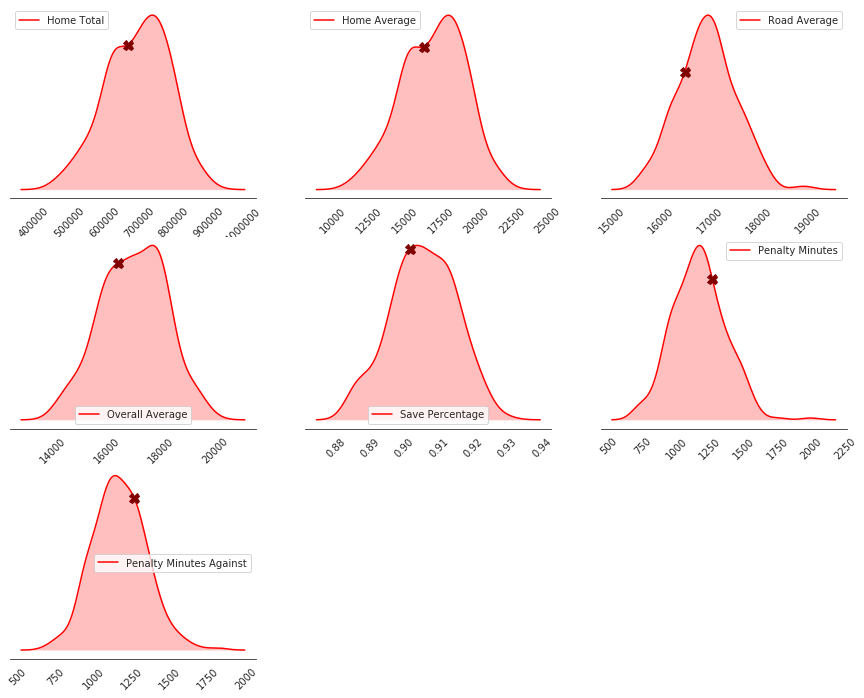

In [64]:
sns.set_style('white')

plt.figure(figsize=(15,12))

plota_kde(df_ESPN, media_dados_ESPN_Jackets, 'Home Total', "331")
plota_kde(df_ESPN, media_dados_ESPN_Jackets, 'Home Average', "332")
plota_kde(df_ESPN, media_dados_ESPN_Jackets, 'Road Average', "333")
plota_kde(df_ESPN, media_dados_ESPN_Jackets, 'Overall Average', "334")
plota_kde(df_ESPN, media_dados_ESPN_Jackets, 'Save Percentage', "335")
plota_kde(df_ESPN, media_dados_ESPN_Jackets, 'Penalty Minutes', "336")
plota_kde(df_ESPN, media_dados_ESPN_Jackets, 'Penalty Minutes Against', "337")

plt.show()

Analisando os dados temos alguns gráficos que merecem destaque:
*  A Média de torcedores por jogo fora de casa da temporada (Road Average) do Columbus Blue Jackets é bem abaixo da média, o que pode identificar um baixo engajamento dos torcedores em relação ao time;
*  Considerando que a curva  de Minutos de penalidade que o time sofreu (Penalty Minutes) possui uma base estreita (valores variando de 500 a 1750) e um pico bem definido (o que indica o valor comum a vários times), conseguimos concluir que o tempo de penalidade do Columbus Blue Jackets possui um valor notadamente maior que os demais. Esse maior tempo de penalidade é então um dos fatores que podem influenciar na má fase do time ao longo dos anos.

### E por fim... O Hockey está ganhando mais espaço ao longo dos anos?
Já vimos alguns fatores que são cruciais para se dar bem nas pistas. Mas será que o esport em si está se dando bem com as pessoas? Vamos ver!

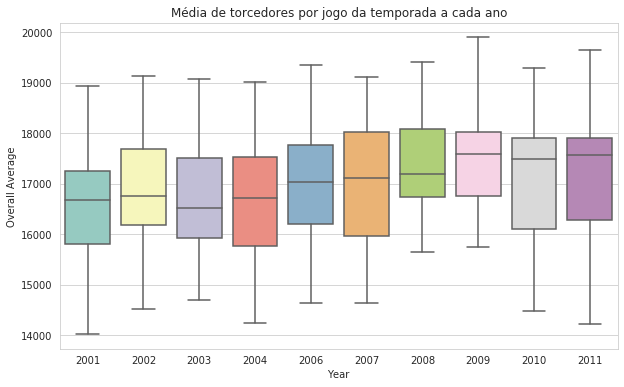

In [84]:
sns.set_style('whitegrid')

plt.figure(figsize=(10,6))

sns.boxplot(x="Year", y="Overall Average", data=df_ESPN, palette="Set3")
plt.title("Média de torcedores por jogo da temporada a cada ano")
plt.show()

Analisando os boxplots ao longo dos anos, percebemos que a média de jogadores tende a aumentar com o passar dos anos, mesmo tendo algumas oscilações. Entretanto, como tais valores não são tão destoantes uns dos outros, vamos realizar um teste de ANOVA para verificar se realmente existe uma média diferente das demais.

In [99]:
# Pega os anos que foram monitorados pelo dataframe
anos = pd.unique(df_ESPN["Year"].values)

# Cria dicionário com os valores
medias_torcedores = {str(ano):df_ESPN["Overall Average"][df_ESPN["Year"] == ano] for ano in anos}

In [102]:
from scipy import stats

# Faz o teste de ANOVA com 1 fator
f, p = stats.f_oneway(medias_torcedores["2001"],
                      medias_torcedores["2002"],
                      medias_torcedores["2003"],
                      medias_torcedores["2004"],
                      medias_torcedores["2006"],
                      medias_torcedores["2007"],
                      medias_torcedores["2008"],
                      medias_torcedores["2009"],
                      medias_torcedores["2010"],
                      medias_torcedores["2011"]
                     )

# printa o p-valor e a estatística f obtido
print("Estatística f: " + str(f))
print("p-valor: " + str(p))

Estatística f: 2.196834904147308
p-valor: 0.02244194960307806


Analisando o p-valor, podemos perceber que ele é um valor muito baixo (abaixo de 0.05), o que indica que nos diversos níveis de confiança (5%, 1% entre outros), podemos afirmar que a hipótese nula não é válida, ou seja, **dentro das médias ao longo dos anos existe, de fato, pelo menos 1 delas que é destoante das demais**. Dessa forma, podemos concluir que realmente houve uma diferença entre as médias e como os boxplots nos indica, uma diferença positiva. Então: SIM, o Hockey está crescendo ao longo dos anos. <br>
Além disso, vale ressaltar que num teste de ANOVA, a hipótese nula é a igualdade entre médias e a hipótese alternativa indica que pelo menos uma delas não é igual as demais. <br>
_Aqui considerei diversas coisas que não deu tempo de analisar por falta de tempo, como: populações normalmente distribuida, populações tem mesma variância (ou mesmo desvio padrão), amostras são aleatórias e mutuamente independentes e as diferentes amostras são obtidas de populações classificadas em apenas uma categoria._

Bom, era isso vlw flw.